# OpenSearch indexing

ETL pipeline is done - but indexing appears painfully slow. From some quick observations with htop and bmon, the bottleneck seems to be OpenSearch calculating the embeddings. But, that's an assumption we can test. Let's make some performance measurements and see what we are working with.

## 1. Run set-up

### 1.1. Imports

In [1]:
# Change working directory to parent so we can import as we would from __main__.py
print(f'Working directory: ', end = '')
%cd ..

# Standard imports
import time

# PyPI imports
import h5py
import matplotlib.pyplot as plt

# Internal imports
import configuration as config
import functions.notebook_helper as helper_funcs

Working directory: /mnt/arkk/opensearch/semantic_search


### 1.2. Run parameters

In [2]:
# Name for the text index to insert to
knn_index_name='wikipedia-knn'
text_index_name='wikipedia-text-only'

# Total record count determined in data exploration notebook
record_count=13778448

# Transformed wikipedia input data
input_file_path=f"{config.DATA_PATH}/wikipedia/{config.TRANSFORMED_TEXT}"

# Initialize the OpenSearch client
client=helper_funcs.start_client()

### 1.3. OpenSearch initialization

Let's make two indexes for comparison: one KNN index with an embedding ingest pipeline and one vanilla text index.

In [3]:
# Create the KNN index
knn_index_body={
    "settings": {
        "number_of_shards": 3,
        "index.knn": "true",
        "default_pipeline": f'{config.INGEST_PIPELINE_ID}'
    },
    "mappings": {
        "properties": {
            "text_embedding": {
                "type": "knn_vector",
                "dimension": 768,
                "method": {
                "engine": "lucene",
                "space_type": "l2",
                "name": "hnsw",
                "parameters": {}
                }
            },
            "text": {
                "type": "text"
            }
        }
    }
}

helper_funcs.initialize_index(knn_index_name, knn_index_body)

# Create the text index
text_index_body={
    'settings': {
        'index': {
            'number_of_shards': 3
        }
    },
    "mappings": {
        "properties": {
            "text": {
                "type": "text"
            }
        }
    }
}

helper_funcs.initialize_index(text_index_name, text_index_body)
# Initialize the OpenSearch client
client=helper_funcs.start_client()

## 2. Insert rate: text only vs embeddings

In [4]:
# number of batches to use for insert rate estimation
sample_batches=3

# Counter for total records inserted
record_num=0

# Collector for insert times
knn_insert_times=[]
text_insert_times=[]

# Open a connection to transformed Wikipedia data
input_data=h5py.File(input_file_path, 'r')

Collect insert performance data for text only and embedding indexes at the same time by inserting to both in the same loop.

In [5]:
# Loop on the batches
for i in range(sample_batches):

    # Load the batch
    batch=input_data[f'batches/{i + 1}']

    # Loop on the records in the batch
    for record in batch:

        record_num+=1

        # Decode the text
        text=record.decode('utf-8')

        # Build the requests
        knn_request=[]
        text_request=[]

        knn_request_header={
            'update': {
                '_index': knn_index_name,
                '_id': record_num
            }
        }

        text_request_header={
            'update': {
                '_index': text_index_name,
                '_id': record_num
            }
        }

        knn_request.append(knn_request_header)
        text_request.append(text_request_header)

        request_body={
            'doc': {
                'text': text
            },
            'doc_as_upsert': 'true'
        }

        knn_request.append(request_body)
        text_request.append(request_body)

        # Insert the record using the bulk interface. We are
        # indexing records one at a time here, but use bulk 
        # for consistency

        # Start the timer
        start_time=time.time()

        _=client.bulk(knn_request)

        # Stop the timer and collect the time
        dT=time.time() - start_time
        knn_insert_times.append(dT)

        # Start the timer
        start_time=time.time()

        _=client.bulk(text_request)

        # Stop the timer and collect the time
        dT=time.time() - start_time
        text_insert_times.append(dT)


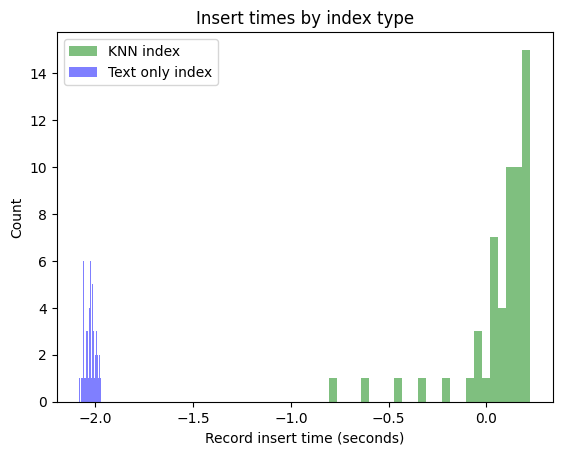

Total text only insert time: 36.1 hours
Text only insert rate: 106 records per second

Total KNN insert time: 202 days
KNN insert rate: 0.789 records per second


In [9]:
import numpy as np

plt.title('Insert times by index type')

plt.hist(
    np.log10(knn_insert_times),
    facecolor='green',
    label='KNN index',
    alpha=0.5,
    bins=25
)

plt.hist(
    np.log10(text_insert_times),
    facecolor='blue',
    label='Text only index',
    alpha=0.5,
    bins=25
)

plt.legend(loc = 'upper left')
plt.xlabel(f'Record insert time (log10(seconds))')
plt.ylabel('Count')
plt.show()

mean_text_insert_time=sum(text_insert_times)/len(text_insert_times)
text_insert_rate=1 / mean_text_insert_time
print(f'Total text only insert time: {(record_count * mean_text_insert_time) / (60*60):.1f} hours')
print(f'Text only insert rate: {text_insert_rate:.0f} records per second\n')

mean_knn_insert_time=sum(knn_insert_times)/len(knn_insert_times)
knn_insert_rate=1 / mean_knn_insert_time
print(f'Total KNN insert time: {(record_count * mean_knn_insert_time) / (60*60*24):.0f} days')
print(f'KNN insert rate: {knn_insert_rate:.3f} records per second')

Yikes, that's not going to work. Looking at the difference in insert rates, it is clear that we were right about the bottleneck: it's definitely the embedding calculation. So, a few ideas here.

1. Though the GPUs are available inside the OpenSearch node Docker containers, OpenSearch is not using them... we should troubleshoot that.
2. We can insert batches with the bulk interface - if that means OpenSearch is calculating the embeddings in parallel, using a larger batch size might speed things up.
3. We could use multiple insert workers - just looking at htop, we are using less than 50% of available CPU resources while inserting, so we should be able to go faster.
4. Last would be reading up on OpenSearch cluster management in general to see if there are settings we should be tuning for this type of thing.

Think that getting the GPUs online is going to be the only real solution here. Given the amount of CPU we are already using while making/inserting embeddings we probably can't speed up much more than two-fold through parallelism alone.

Let's at least try bigger bulk batches first.

## 3. Insert rate: bulk insert batch size

In [7]:
# Bulk insert batch sizes to test
batch_sizes=[1,2,4,8,16]

# Replicates for each batch size
batch_size_replicates=3

# Holder for results
results={}

Only need to test the KNN index rates here - that's what we are really after.

In [8]:
for batch_size in batch_sizes:

    # Add the batch size to the results
    results[f'{batch_size}']=[]

    # Start an empty collector for the insert batch
    bulk_insert_batch=[]

    # Loop on the batches
    for i in range(sample_batches):

        # Load the batch
        batch=input_data[f'batches/{i + 1}']

        # Loop on the records in the batch
        for record in batch:

            record_num+=1

            # Decode the text
            text=record.decode('utf-8')

            # Add it to the batch
            bulk_insert_batch.append(text)

            # Once we have enough records in the bulk insert batch, insert it
            if len(bulk_insert_batch) == batch_size:

                # Build the requests
                knn_requests=[]

                for text in bulk_insert_batch:

                    knn_request_header={
                        'update': {
                            '_index': knn_index_name,
                            '_id': record_num
                        }
                    }

                    knn_requests.append(knn_request_header)

                    request_body={
                        'doc': {
                            'text': text
                        },
                        'doc_as_upsert': 'true'
                    }

                    knn_requests.append(request_body)

                # Insert the record using the bulk interface. We are
                # indexing records one at a time here, but use bulk 
                # for consistency

                # Start the timer
                start_time=time.time()

                _=client.bulk(knn_request)

                # Stop the timer and collect the time
                dT=time.time() - start_time
                results[f'{batch_size}'].append(dT)

                # Reset the bulk insert batch for the next round
                bulk_insert_batch=[]

            # If we have completed the desired number of replicates break out of the
            # inner loop to star the next batch size
            if len(results[f'{batch_size}']) == batch_size:
                break

/tmp/ipykernel_1257123/4174334943.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc = 'upper left')


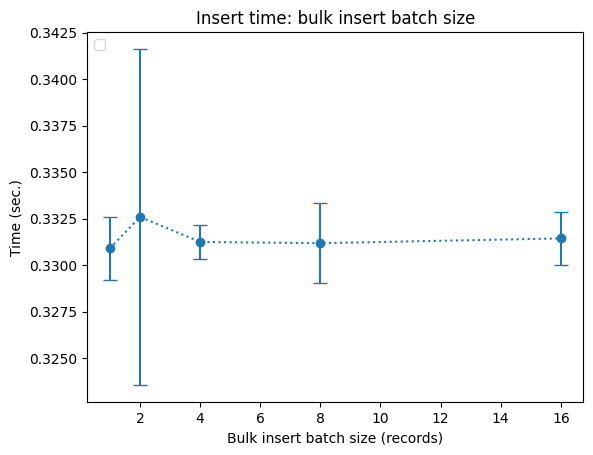

In [13]:
plt.title('Insert time: bulk insert batch size')
plt.xlabel('Bulk insert batch size (records)')
plt.ylabel('Time (sec.)')

standard_deviations=[]
means=[]

for batch_size in batch_sizes:
    times=results[f'{batch_size}']
    means.append(np.mean(times))
    standard_deviations.append(np.std(times))

plt.errorbar(
    batch_sizes, 
    means, 
    yerr=standard_deviations, 
    linestyle='dotted', 
    marker='o', 
    capsize=5
)

plt.legend(loc = 'upper left')
plt.show()



I was afraid of that - no effect of bulk insert batch size on overall insert time. My guess is that OpenSearch is just calculating the embeddings one at a time, regardless of how many text chunks we send. It could be that there is some setting we can tweak to allow multiple jobs, but as it stands: no benefit.